This notebook walks you through the process of human data collection from the original open-sources.

First, we download the data from the listed sources and analyze it. Then, we choose suitable samples for our project and preprocess them. The files created by this code - social_media.csv, news.csv and poems.csv - were used in the second notebook **Human Data Partition**.

Please make sure to adjust the file paths according to your setup.

In [ ]:
import pandas as pd
import string
import re
from nltk.tokenize import word_tokenize, sent_tokenize
from tqdm import tqdm
import matplotlib.pyplot as plt

# Collecting Datasets

## Social Media

###Pikabu dataset by Ilya Gusev
Source: https://huggingface.co/datasets/IlyaGusev/pikabu

Description: Dataset of posts and comments from pikabu.ru, a website that is Russian Reddit/9gag.

I'm creating a subset of 200k samples from this dataset because its total size is too large.

In [ ]:
pip install datasets zstandard jsonlines pysimdjson

In [ ]:
from datasets import load_dataset

# Function provided by the author of the dataset
def revert_flattening(records):
    """
    Unflattens sequences of records into a list of dictionaries.
    """
    fixed_records = []
    for key, values in records.items():
        if not fixed_records:
            fixed_records = [{} for _ in range(len(values))]
        for i, value in enumerate(values):
            fixed_records[i][key] = value
    return fixed_records

In [ ]:
def collect_texts(dataset_name, split="train"):
    """
    Collect all 'text_markdown' entries from both parent posts and nested comments,
    stopping when the number of instances reaches 200,000.

    Args:
        dataset_name (str): The name of the dataset on Hugging Face.
        split (str): Dataset split to use (default: "train").

    Returns:
        List[str]: A list of all 'text_markdown' strings from the dataset, capped at 200,000 entries.
    """
    texts = []
    dataset = load_dataset(dataset_name, split=split, streaming=True)

    for example in dataset:
        # Collect parent-level 'text_markdown'
        if "text_markdown" in example:
            texts.append(example["text_markdown"])

        if len(texts) >= 200_000:
            break

        # Collect nested 'comments' 'text_markdown'
        if "comments" in example and "text_markdown" in example["comments"]:
            nested_comments = revert_flattening(example["comments"])
            for comment in nested_comments:
                if "text_markdown" in comment:
                    texts.append(comment["text_markdown"])

                    if len(texts) >= 200_000:
                        break

        if len(texts) >= 200_000:
            break

    return texts

In [ ]:
all_texts = collect_texts("IlyaGusev/pikabu", split="train")

In [ ]:
# Check if length is sufficient
len(all_texts)

200000

In [ ]:
df_p = pd.DataFrame({
    'texts': all_texts,
    'source': ['pikabu'] * len(all_texts)  # Assign 'pikabu' to all rows in the 'source' column
})

In [ ]:
df_p.head(10)

,texts,source
0,Осенью в России стартовали продажи очередной м...,pikabu
1,"""Про такую «маржу» любят рассказывать инфоцыга...",pikabu
2,Я ж привел среднюю по Я.Маркету,pikabu
3,"@moderator, тут человек на айфон залупается. М...",pikabu
4,алкатель ван лва,pikabu
5,"Если бы пробовал, подобного бы не писал.",pikabu
6,так на авито продается почти все,pikabu
7,"И ты действительно уверен, что сможешь продать...",pikabu
8,"ну не разом, но в течении месяца вполне возможно",pikabu
9,Я так и не понял сути поста? Блин в Китае дохе...,pikabu


In [ ]:
# Save to file
df_p.to_csv('data/original/pikabu/subset_pikabu.csv', index=False)

###Taiga Corpus - Social Media Segment
Source: https://tatianashavrina.github.io/taiga_site/segments

I chose to work with texts from from Vkontakte (Russian Facebook equivalent) and Facebook only.

**Vkontakte**

In [ ]:
# Function to parse txt files into a pandas dataframe

def create_pandas_database(file_path):
    data = []
    source = "vk"

    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for line in lines:
        if line.startswith("DataBaseItem"):
            continue

        cleaned_line = re.sub(r'\[id\d+\|[^\]]+\],?\s*', '', line).strip()

        if cleaned_line:
            data.append({'texts': cleaned_line, 'source': source})

    df = pd.DataFrame(data)
    return df

In [ ]:
# Adjust the path according to your set up!
df_vk = create_pandas_database("data/original/taiga/vktexts.txt")

In [ ]:
df_vk.head(10)

,texts,source
0,﻿DataBaseItem: 6_5756d99b5dd2dc3dac164155,vk
1,"Кстати, как неожиданно КПРФ стало не все равно...",vk
2,"можно и по-другому сказать: ""убогая клоунада"" ...",vk
3,Вот он тонкий незаметный ход против России. Зю...,vk
4,просто в этом паблике раньше подобных постов н...,vk
5,Это не КПРФ - это цирк. Коммунизм - это совсем...,vk
6,Почему?? .. Ведь все начинается с низов. Помню...,vk
7,"вот писал, писал, а потом понял что ты видимо ...",vk
8,так вариантов два..Зюганов или оральный..Кто е...,vk
9,речь о том что мои прадеды уничтожали паразити...,vk


In [ ]:
len(df_vk)

306641

In [ ]:
def validate_cleaned_data(df):
    issues = []
    for index, row in df.iterrows():
        text = row['texts']
        # Check for DataBaseItem or [id...] patterns
        if 'DataBaseItem' in text or re.search(r'\\[id\\d+\\|[^\\]]+\\]', text):
            issues.append((index, text))

    if issues:
        print(f"Found issues in {len(issues)} rows:")
        for issue in issues:
            print(f"Row {issue[0]}: {issue[1]}")
    else:
        print("No issues found. All rows are clean.")

In [ ]:
validate_cleaned_data(df_vk)

Found issues in 1 rows:
Row 0: ﻿DataBaseItem: 6_5756d99b5dd2dc3dac164155


In [ ]:
df_vk = df_vk.iloc[1:].reset_index(drop=True)

In [ ]:
df_vk.head(10)

,texts,source
0,"Кстати, как неожиданно КПРФ стало не все равно...",vk
1,"можно и по-другому сказать: ""убогая клоунада"" ...",vk
2,Вот он тонкий незаметный ход против России. Зю...,vk
3,просто в этом паблике раньше подобных постов н...,vk
4,Это не КПРФ - это цирк. Коммунизм - это совсем...,vk
5,Почему?? .. Ведь все начинается с низов. Помню...,vk
6,"вот писал, писал, а потом понял что ты видимо ...",vk
7,так вариантов два..Зюганов или оральный..Кто е...,vk
8,речь о том что мои прадеды уничтожали паразити...,vk
9,"Крещение Руси в Киеве было.Зюганов что, теперь...",vk


**Facebook**

In [ ]:
def create_fb_database(file_path):
    data = []
    source = "fb"

    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # Initialize a buffer to store the text between DataBaseItem lines
    buffer = ""

    for line in lines:
        # Check if the line starts with DataBaseItem
        if line.startswith("DataBaseItem"):
            # If buffer has content, save it as a new entry
            if buffer.strip():
                data.append({'texts': buffer.strip(), 'source': source})
                buffer = ""
        else:
            buffer += line

    # Add any remaining buffered text
    if buffer.strip():
        data.append({'texts': buffer.strip(), 'source': source})

    df = pd.DataFrame(data)
    return df

In [ ]:
# Adjust the path according to your set up!
df_fb = create_fb_database("data/original/taiga/fbtexts.txt")

In [ ]:
df_fb.head(10)

,texts,source
0,﻿DataBaseItem: 7_5756d9845dd2dc3dac16301f\nА К...,fb
1,"Я,все таки,думаю,что этот дигенерат бросил тен...",fb
2,"===========================\n\nЛадно, гулять ,...",fb
3,ну с какого перепугу КПРФ - оппозиционная? Мо...,fb
4,Пётр Ткалич Что -то с памятью у Вас ... ...,fb
5,Владимир Овсянников Павленский Ван-гог нашего...,fb
6,"Он может быть, являться кем угодно. Точно так...",fb
7,"Жириновский,когда ты уже эту единоросскую шобл...",fb
8,Офшор не так работает. Находите человека котор...,fb
9,"Vira Savchenko ""новососсии"" и так нет. А на пр...",fb


In [ ]:
len(df_fb)

136809

In [ ]:
# Create one joint dataframe
social = pd.concat([df_vk, df_fb, df_p], ignore_index=True)

In [ ]:
social['source'].value_counts()

,count
source,
vk,306640
pikabu,200000
fb,136809


In [ ]:
len(social)

643449

In [ ]:
# Deleting null values
social = social.dropna(subset=['texts'])

In [ ]:
social.isnull().sum()

,0
texts,0
source,0


In [ ]:
len(social)

638320

In [ ]:
# Save to file if needed
social.to_csv("data/original/social_media.csv", index=False, encoding='utf-8')
print("File saved as social_media.csv")

File saved as social_media.csv


## Russian News Dataset 2020
Source: https://www.kaggle.com/datasets/vfomenko/russian-news-2020

21670 news collected from 4 news sites: Ria, Lenta, Meduza, Tjournal.


In [ ]:
# Make sure to adjust the path
df_news = pd.read_csv("data/original/news/news.csv")
df_news.head()

,source,title,text,publication_date,rubric,subrubric,tags
0,lenta.ru,Синий богатырь,В 1930-е годы Советский Союз охватила лихорадк...,2020-08-30T00:01:00+03:00,Экономика,Госэкономика,NaN
1,lenta.ru,Загитова согласилась вести «Ледниковый период»,Олимпийская чемпионка по фигурному катанию Ал...,2020-08-31T20:04:00+03:00,Спорт,Зимние виды,NaN
2,lenta.ru,Объяснена опасность однообразного питания,Российский врач-диетолог Римма Мойсенко объясн...,2020-08-31T20:07:00+03:00,Из жизни,Еда,NaN
3,lenta.ru,«Предохраняться? А зачем?»,В 2019 году телеканал «Ю» запустил адаптацию з...,2020-08-30T00:04:00+03:00,Интернет и СМИ,ТВ и радио,NaN
4,lenta.ru,Ефремов систематически употреблял наркотики,Актер Михаил Ефремов систематически употребл...,2020-08-31T18:27:00+03:00,Культура,Кино,NaN


In [ ]:
df_news['source'].value_counts()

,count
source,
ria.ru,14755
lenta.ru,4510
meduza.io,1538
tjournal.ru,870


In [ ]:
len(df_news)

21673

In [ ]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21673 entries, 0 to 21672
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   source            21673 non-null  object
 1   title             21670 non-null  object
 2   text              21673 non-null  object
 3   publication_date  21673 non-null  object
 4   rubric            4503 non-null   object
 5   subrubric         4473 non-null   object
 6   tags              14752 non-null  object
dtypes: object(7)
memory usage: 1.2+ MB


In [ ]:
# There is something wrong with news from tjournal.
df_news[df_news['source'] == 'tjournal.ru'].sample(10)

,source,title,text,publication_date,rubric,subrubric,tags
20868,tjournal.ru,\n «Двое чиновников...,\n\n \n \n \n \n \n...,1596118512,NaN,NaN,NaN
20928,tjournal.ru,\n МВД возбудило де...,\n\n \n \n \n \n \n...,1593103580,NaN,NaN,NaN
21640,tjournal.ru,\n В Госдуме раскри...,\n\n \n \n \n \n \n...,1578740704,NaN,NaN,NaN
21250,tjournal.ru,\n Страны Евразийск...,\n\n \n \n \n \n \n...,1585721606,NaN,NaN,NaN
21031,tjournal.ru,\n HBO опубликовал ...,\n\n \n \n \n \n \n...,1590001593,NaN,NaN,NaN
21615,tjournal.ru,\n От ракетного уда...,\n\n \n \n \n \n \n...,1579241007,NaN,NaN,NaN
21179,tjournal.ru,\n Исследование: ле...,\n\n \n \n \n \n \n...,1586919232,NaN,NaN,NaN
21495,tjournal.ru,\n В Москве запустя...,\n\n \n \n \n \n \n...,1581416544,NaN,NaN,NaN
21129,tjournal.ru,\n В Москве начали ...,\n\n \n \n \n \n \n...,1587672677,NaN,NaN,NaN
21126,tjournal.ru,\n В России построя...,\n\n \n \n \n \n \n...,1587655423,NaN,NaN,NaN


In [ ]:
df_news.at[20971, 'text']

'\n\n    \n    \n        \n        \n        \n             \n    \n         Из-за коронавируса забирать невесту теперь можно только на двух машинах, а на свадьбе могут присутствовать только близкие родственники. \n     \n\n        \n        \n            \n                                 \n                                             \n                        \n \n     \n\n         \n\n         \n         55 \n\n        \n             комментариев \n\n             \n \n                    \n                     \n                    \n \n\n     \n    \n             В закладки \n    \n     \n \n\n                     \n                                            \n \n          Слушать \n \n                    \n                     \n                    \n \n\n     \n\n        \n             \n\n                 \n             \n\n        \n             \n\n                 \n             \n\n        \n             \n\n                 \n             \n\n        \n             \n\n   

I will not keep news from tjournal.ru.

In [ ]:
df_news = df_news[df_news['source'] != 'tjournal.ru']

In [ ]:
df_news = df_news.rename(columns={'text': 'texts'})[['title', 'texts', 'source']]

In [ ]:
df_news.sample(10)

,title,texts,source
13378,Ким Чен Ын впервые за 20 дней появился на публике,"МОСКВА, 2 мая - РИА Новости. Государственные ...",ria.ru
4162,Россиянин изнасиловал 10-летнюю девочку в авто...,В Сочи 59-летний мужчина изнасиловал ребенка в...,lenta.ru
19925,В египетской Александрии после реставрации отк...,"АЛЕКСАНДРИЯ, 10 янв - РИА Новости, Рафаэль Дам...",ria.ru
14464,ОПЕК+ в декабре 2021 года рассмотрит возможнос...,"МОСКВА, 13 апр - РИА Новости. Страны ОПЕК + ...",ria.ru
5807,Новый коронавирус нашли у шести тысяч человек....,"Число людей, инфицированных новым типом корона...",meduza.io
7949,"Фильм ""Чернобыль"" от HBO признали лучшим мини-...","ЛОНДОН, 1 авг — РИА Новости, Наталья Копылов...",ria.ru
13049,Наука на войне: как разработки советских учены...,"МОСКВА, 7 мая — РИА Новости. Труды советски...",ria.ru
5928,Британский стартап бывшего главы Yota оценили ...,"Инвесторы оценили британский стартап Arrival, ...",meduza.io
9378,В Грузии локализовали пожар в пятизвездочной г...,"ТБИЛИСИ, 8 июл - РИА Новости. Пожар в пятизве...",ria.ru
5671,Samsung показала новые телефоны,Компания Samsung провела 11 февраля в Сан-Фран...,meduza.io


Texts from Ria.ru seem to often begin with the city name, date, and "RIA News," such as "МОСКВА, 29 мая – РИА Новости." This pattern could become a giveaway for the model to identify human-written text, so it needs to be removed.

In [ ]:
df_news[df_news['source'] == 'ria.ru'].sample(10)

,title,texts,source
12233,Российские власти проведут совещание по образо...,"МОСКВА, 21 мая - РИА Новости. Совещание по те...",ria.ru
8405,Легойда: поддержка схимонаха Сергия его адепта...,"МОСКВА, 24 июл - РИА Новости. Причина популяр...",ria.ru
7724,Драка с участием украинской топ-модели на пляж...,"МОСКВА, 5 авг — РИА Новости. Турецкое издание...",ria.ru
10065,"Создатели ""Аватара 2"" показали, как проходят с...","МОСКВА, 26 июн — РИА Новости. В официальном т...",ria.ru
17323,"""Он психанул"": инсайдер рассказал об уходе Шеп...","МОСКВА, 24 фев — РИА Новости. Телеведущий Дм...",ria.ru
8352,СМИ: Трампа разозлил запрет флага конфедератов...,"МОСКВА, 25 июл - РИА Новости. Президент США ...",ria.ru
8978,В Долгопрудном ликвидировали пожар на обувном ...,"МОСКВА, 15 июл - РИА Новости. Спасатели ликви...",ria.ru
15988,Крым отмечает шестую годовщину воссоединения с...,"СИМФЕРОПОЛЬ, 18 мар – РИА Новости. Крым отм...",ria.ru
11463,ЦПК заказал создание тренажера нового пилотиру...,"МОСКВА, 3 июн - РИА Новости. Центр подготовк...",ria.ru
6274,В ДНР заявили о первом за восемь дней обстреле...,"МОСКВА, 29 авг — РИА Новости. Украинские сило...",ria.ru


In [ ]:
# At the end of the text there is also a giveaway sentence: Материал подготовлен на основе информации РИА Новости и открытых источников.
print(df_news['texts'][11666])

Коммерческая программа пилотируемых космических полетов Национального управления по аэронавтике и исследованию космического пространства (National Aeronautics and Space Administration, NASA/ НАСА ) "Коммерческий экипаж" (NASA’s Commercial Crew Program) представляет собой сотрудничество государственных и частных структур в области освоения космоса.  Для полетов человека в космос NASA  использовало подобную модель с 1960-х годов , начиная с программы Mercury и заканчивая программой Space Shuttle.  С июля 2011 года после вывода из эксплуатации американской многоразовой пилотируемой транспортной системы Space Shuttle российские корабли "Союз" стали единственным средством доставки экипажей на Международную космическую станцию (МКС). По данным NASA, с 2006 года  США  приобрели у России 72 места в кораблях "Союз" на сумму более четырех миллиардов долларов для доставки американских, европейских, канадских и японских астронавтов на станцию и обратно на Землю. За это время стоимость полета для н

In [ ]:
def remove_ria_intro(text):
    """
    Removes the first sentence from the text if it contains 'РИА Новости'.
    """

    sentences = sent_tokenize(text)

    if sentences and 'РИА Новости' in sentences[0]:
        sentences = sentences[1:]

    cleaned_text = ' '.join(sentences)
    return cleaned_text

In [ ]:
# Testing this function on a dummy sentence
sample_text = "МОСКВА, 29 мая – РИА Новости. Это текст новости. Коммерческая программа пилотируемых космических полетов Национального управления по аэронавтике и исследованию космического пространства (National Aeronautics and Space Administration, NASA/ НАСА ) 'Коммерческий экипаж' (NASA’s Commercial Crew Program) представляет собой сотрудничество государственных и частных структур в области освоения космоса.  Для полетов человека в космос NASA  использовало подобную модель с 1960-х годов , начиная с программы Mercury и заканчивая программой Space Shuttle.  С июля 2011 года после вывода из эксплуатации американской многоразовой пилотируемой транспортной системы Space Shuttle российские корабли 'Союз' стали единственным средством доставки экипажей на Международную космическую станцию (МКС)."
cleaned_text = remove_ria_intro(sample_text)
print(cleaned_text)

Это текст новости. Коммерческая программа пилотируемых космических полетов Национального управления по аэронавтике и исследованию космического пространства (National Aeronautics and Space Administration, NASA/ НАСА ) 'Коммерческий экипаж' (NASA’s Commercial Crew Program) представляет собой сотрудничество государственных и частных структур в области освоения космоса. Для полетов человека в космос NASA  использовало подобную модель с 1960-х годов , начиная с программы Mercury и заканчивая программой Space Shuttle. С июля 2011 года после вывода из эксплуатации американской многоразовой пилотируемой транспортной системы Space Shuttle российские корабли 'Союз' стали единственным средством доставки экипажей на Международную космическую станцию (МКС).


In [ ]:
# Applying the fuction to texts from Ria news
df_news.loc[df_news['source'] == 'ria.ru', 'texts'] = df_news.loc[df_news['source'] == 'ria.ru', 'texts'].apply(remove_ria_intro)

In [ ]:
df_news.sample(10)

,title,texts,source
507,Трампа заподозрили в криминальной деятельности,"Прокурор округа Нью-Йорк Сайрус Вэнс заявил, ч...",lenta.ru
10704,В Грозном возобновили регулярные рейсы в росси...,Регулярные ежедневные рейсы из Грозного в М...,ria.ru
20647,"Роспотребнадзор объяснил, как получить все ден...",Роспотребнадзор в преддверии Нового года да...,ria.ru
1049,Российский космонавт рассказал о сложностях жи...,Российский космонавт Иван Вагнер рассказал о с...,lenta.ru
10891,В Подмосковье заработали летние веранды кафе и...,Летние веранды кафе и ресторанов открылись в ...,ria.ru
11005,СМИ: два пакистанских военных погибли при взры...,По меньшей мере двое пакистанских военнослужащ...,ria.ru
1439,В России отреагировали на желание Зеленского п...,Предложение президента Украины Владимира Зеле...,lenta.ru
2643,В Москве возле больницы образовалась пробка из...,В Москве образовалась единственная в городе пр...,lenta.ru
18463,Первый самолет ВКС с россиянами из Уханя сел н...,"Первый самолет ВКС РФ , вылетевший во вторник...",ria.ru
9611,Названы самые безопасные места во время летней...,Попадание молнии в человека может быть смертел...,ria.ru


**Handling titles**

- I will concatenate the title with the main body text to include titles in future generation and detection experiments, as they can be essential for certain genres, such as poems and news.

- Additionally, I will keep the title column in case it's needed.

In [ ]:
df_news['texts'] = df_news['title'] + '\n' + df_news['texts']

In [ ]:
df_news.head()

,title,texts,source
0,Синий богатырь,Синий богатырь\nВ 1930-е годы Советский Союз о...,lenta.ru
1,Загитова согласилась вести «Ледниковый период»,Загитова согласилась вести «Ледниковый период»...,lenta.ru
2,Объяснена опасность однообразного питания,Объяснена опасность однообразного питания\nРос...,lenta.ru
3,«Предохраняться? А зачем?»,«Предохраняться? А зачем?»\nВ 2019 году телека...,lenta.ru
4,Ефремов систематически употреблял наркотики,Ефремов систематически употреблял наркотики\nА...,lenta.ru


In [ ]:
df_news.isnull().sum()

,0
title,0
texts,0
source,0


In [ ]:
df_news = df_news.drop_duplicates(subset='texts')

In [ ]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20802 entries, 0 to 20802
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   20802 non-null  object
 1   texts   20802 non-null  object
 2   source  20802 non-null  object
dtypes: object(3)
memory usage: 650.1+ KB


##Poems Dataset
Source: https://www.kaggle.com/datasets/grafstor/19-000-russian-poems/data

19 315 poems, 48 authors. 18-20th century.


In [ ]:
# Adjust the path according to your set up
df_poems = pd.read_csv('data/original/poems/poems.csv')
df_poems.head()

,writer,poem,text
0,Лермонтов Михаил Юрьевич,Любовь мертвеца,NaN
1,Лермонтов Михаил Юрьевич,На серебряные шпоры…,На серебряные шпоры\nЯ в раздумии гляжу;\nЗа т...
2,Лермонтов Михаил Юрьевич,Вид гор из степей Козлова,Пилигрим\nАллах ли там среди пустыни\nЗастывши...
3,Лермонтов Михаил Юрьевич,"К (О, не скрывай! Ты плакала об нем…)","О, не скрывай! Ты плакала об нем –\nИ я его лю..."
4,Лермонтов Михаил Юрьевич,"Жалобы турка (письмо к другу, иностранцу)","Ты знал ли дикий край, под знойными лучами,\nГ..."


In [ ]:
df_poems = df_poems.drop_duplicates().dropna()

In [ ]:
len(df_poems)

19302

In [ ]:
# Restructure the dataset for consistency with other genres
df_poems = df_poems.rename(columns={'poem': 'title', 'text': 'texts', 'writer': 'source'})
df_poems['genre'] = 'poems'
df_poems = df_poems[['title', 'texts', 'source', 'genre']]

In [ ]:
# Concatenating titles with main texts
df_poems['texts'] = df_poems['title'] + '\n' + df_poems['texts']

In [ ]:
df_poems.head()

,title,texts,source,genre
1,На серебряные шпоры…,На серебряные шпоры…\nНа серебряные шпоры\nЯ в...,Лермонтов Михаил Юрьевич,poems
2,Вид гор из степей Козлова,Вид гор из степей Козлова\nПилигрим\nАллах ли ...,Лермонтов Михаил Юрьевич,poems
3,"К (О, не скрывай! Ты плакала об нем…)","К (О, не скрывай! Ты плакала об нем…)\nО, не ...",Лермонтов Михаил Юрьевич,poems
4,"Жалобы турка (письмо к другу, иностранцу)","Жалобы турка (письмо к другу, иностранцу)\nТы ...",Лермонтов Михаил Юрьевич,poems
5,К кн. Л. Г-ой,К кн. Л. Г-ой\nКогда ты холодно внимаешь\nРасс...,Лермонтов Михаил Юрьевич,poems


In [ ]:
df_poems['source'].value_counts()

,count
source,
Брюсов Валерий Яковлевич,1607
Игорь Северянин,1597
Александр Петрович Сумароков,1520
Блок Александр Александрович,1282
Маяковский Владимир Владимирович,1279
Фёдор Кузьмич Сологуб,1163
Бальмонт Константин Дмитриевич,990
Фет Афанасий Афанасьевич,888
Пушкин Александр Сергеевич,750


In [ ]:
df_poems.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19302 entries, 1 to 19315
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   19302 non-null  object
 1   texts   19302 non-null  object
 2   source  19302 non-null  object
 3   genre   19302 non-null  object
dtypes: object(4)
memory usage: 1.2+ MB


# Adding word counts for each genre

In [ ]:
def word_count(text):
    '''
    Tokenizes the text into words, excludes punctuation but retains the numbers, and counts word tokens.
    Returns the word tokens.
    '''

    tokens = word_tokenize(text)
    word_tokens = [word for word in tokens if word.isalnum()]

    return len(word_tokens)

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

**Calculating word count for the socail media dataset.**

In [ ]:
# This takes apx. 7 min to execute
tqdm.pandas()

social['word_counts'] = social['texts'].progress_apply(word_count)

100%|██████████| 638320/638320 [06:34<00:00, 1619.96it/s]


In [ ]:
social.head()

,texts,source,word_counts,genre
0,"Кстати, как неожиданно КПРФ стало не все равно...",vk,14,social
1,"можно и по-другому сказать: ""убогая клоунада"" ...",vk,36,social
2,Вот он тонкий незаметный ход против России. Зю...,vk,23,social
3,просто в этом паблике раньше подобных постов н...,vk,21,social
4,Это не КПРФ - это цирк. Коммунизм - это совсем...,vk,12,social


In [ ]:
# checking if the function works correctly.
print(social['texts'][4])
print(social['texts'][0])

Это не КПРФ - это цирк. Коммунизм - это совсем другая идеология. Дибилы, бл**
Кстати, как неожиданно КПРФ стало не все равно на судьбу фермеров именно накануне выборов)


In [ ]:
social['genre'] = 'social'

In [ ]:
# there are 0 word counts, which must be a mistake.
social['word_counts'].describe()

,word_counts
count,638320.000000
mean,41.533416
std,96.648498
min,0.000000
25%,10.000000
50%,19.000000
75%,40.000000
max,5780.000000


In [ ]:
# let's try this again
social = social.drop_duplicates().dropna()

In [ ]:
social[social['word_counts'] == 0]

,texts,source,word_counts,genre
4833,✔За✔ КПРФ❗,vk,0,social
14766,Потрачено.Original:,vk,0,social
26758,27.02.16.Череповец.КПРФ.20160227_12313527.02.1...,vk,0,social
31251,27.02.16.г.Череповец.КПРФ.Паутова НадеждаБорис...,vk,0,social
43807,🍀🍀🍀ВЗАМИНОЕ ВЗАИМНО🍀БЫСТРО🍀НАДОЛГО🍀,vk,0,social
...,...,...,...,...
642611,eto.prosto.ohuenno.,pikabu,0,social
642634,Как_нарисовать_сову.жпег*,pikabu,0,social
642693,[:|||||||:],pikabu,0,social
642713,#comment_145814386,pikabu,0,social


In [ ]:
# I will remove such instances from my df as I have enough samples
social = social[social['word_counts'] != 0]

In [ ]:
len(social)

632216

In [ ]:
social['word_counts'].describe()

,word_counts
count,632216.000000
mean,41.794195
std,96.888329
min,1.000000
25%,10.000000
50%,20.000000
75%,41.000000
max,5780.000000


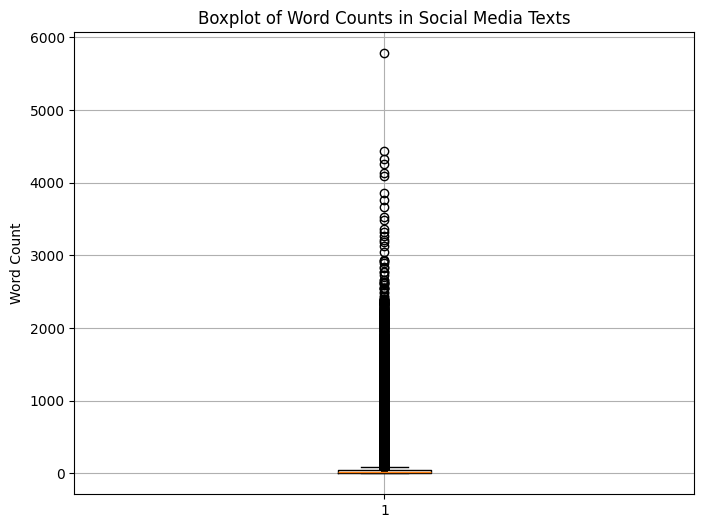

In [ ]:
# Boxplot for the 'word_counts' column
plt.figure(figsize=(8, 6))
plt.boxplot(social['word_counts'], vert=True)
plt.title('Boxplot of Word Counts in Social Media Texts')
plt.ylabel('Word Count')
plt.grid(True)
plt.show()

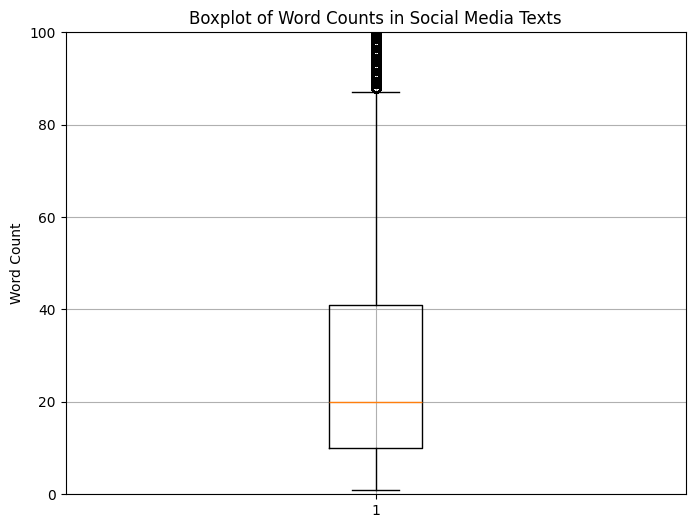

In [ ]:
plt.figure(figsize=(8, 6))
plt.boxplot(social['word_counts'], vert=True)
plt.ylim(0, 100)
plt.title('Boxplot of Word Counts in Social Media Texts')
plt.ylabel('Word Count')
plt.grid(True)
plt.show()

In [ ]:
len(social)

632216

In [ ]:
# Save to file
social.to_csv("data/original/social_media.csv", index=False, encoding='utf-8')
print("File saved as social_media.csv")

File saved as social_media.csv


**Calculating word count for the news dataset.**

In [ ]:
tqdm.pandas()

df_news['word_counts'] = df_news['texts'].progress_apply(word_count)

100%|██████████| 20802/20802 [00:56<00:00, 364.97it/s]


In [ ]:
df_news['genre'] = 'news'

In [ ]:
df_news.sample(4)

,title,texts,source,word_counts,genre
3205,В Сирии погиб российский военный,В Сирии погиб российский военный\nРоссийский в...,lenta.ru,159,news
12418,"Эксперты рассказали, как бесплатно попасть в б...","Эксперты рассказали, как бесплатно попасть в б...",ria.ru,219,news
5478,Полиция объяснила гибель кошек на рейсе «Аэроф...,Полиция объяснила гибель кошек на рейсе «Аэроф...,meduza.io,86,news
10644,В Пекине выявили почти 40 новых случаев COVID-19,В Пекине выявили почти 40 новых случаев COVID-...,ria.ru,231,news


In [ ]:
df_news = df_news[df_news['word_counts'] != 0]

In [ ]:
df_news['word_counts'].describe()

,word_counts
count,20802.000000
mean,234.511345
std,263.533572
min,7.000000
25%,128.000000
50%,175.000000
75%,246.000000
max,7227.000000


In [ ]:
# this is not really a news article. I'll delete it.
df_news[df_news['word_counts'] == 7]

,title,texts,source,word_counts,genre
6170,"Лучшие фото РИА Новости, август 2020 года","Лучшие фото РИА Новости, август 2020 года \n",ria.ru,7,news


In [ ]:
df_news = df_news[df_news['word_counts'] != 7]

In [ ]:
df_news['word_counts'].describe()

,word_counts
count,20801.000000
mean,234.522283
std,263.535185
min,19.000000
25%,128.000000
50%,175.000000
75%,246.000000
max,7227.000000


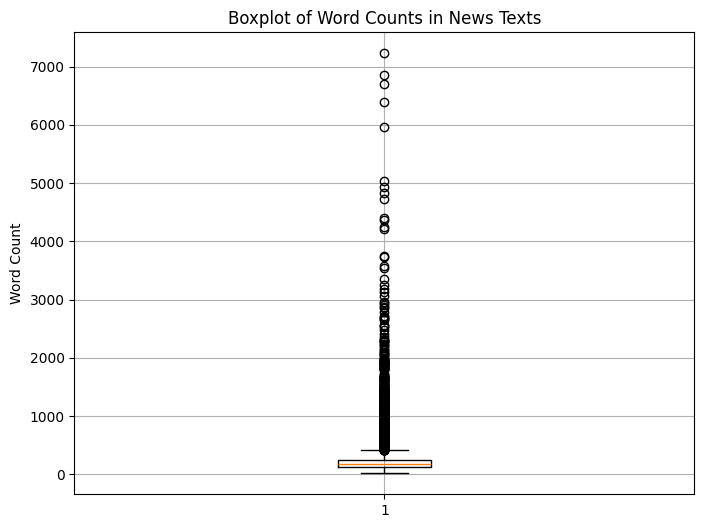

In [ ]:
# Boxplot for the 'word_counts' column
plt.figure(figsize=(8, 6))
plt.boxplot(df_news['word_counts'], vert=True)
plt.title('Boxplot of Word Counts in News Texts')
plt.ylabel('Word Count')
plt.grid(True)
plt.show()

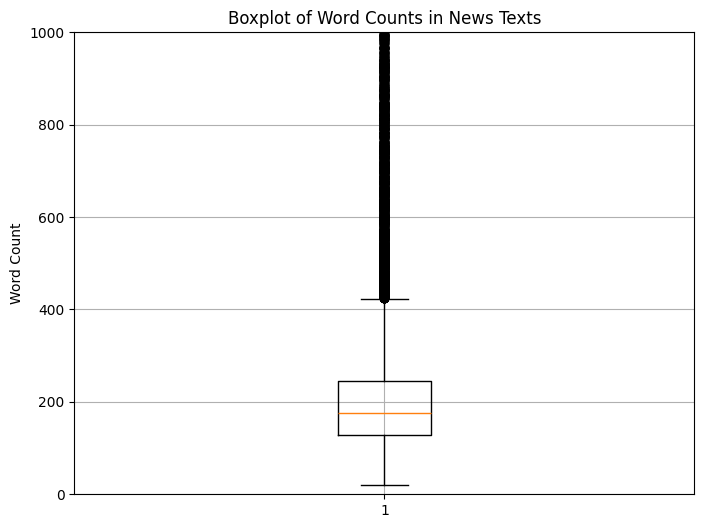

In [ ]:
plt.figure(figsize=(8, 6))
plt.boxplot(df_news['word_counts'], vert=True)
plt.ylim(0, 1000)
plt.title('Boxplot of Word Counts in News Texts')
plt.ylabel('Word Count')
plt.grid(True)
plt.show()

In [ ]:
len(df_news)

20801

In [ ]:
# Save to files
df_news.to_csv("data/original/news.csv", index=False, encoding='utf-8')
print("File saved as news.csv")

File saved as news.csv


**Calculating word count for the poems dataset.**

In [ ]:
df_poems.head()

,title,texts,source,genre
1,На серебряные шпоры…,На серебряные шпоры…\nНа серебряные шпоры\nЯ в...,Лермонтов Михаил Юрьевич,poems
2,Вид гор из степей Козлова,Вид гор из степей Козлова\nПилигрим\nАллах ли ...,Лермонтов Михаил Юрьевич,poems
3,"К (О, не скрывай! Ты плакала об нем…)","К (О, не скрывай! Ты плакала об нем…)\nО, не ...",Лермонтов Михаил Юрьевич,poems
4,"Жалобы турка (письмо к другу, иностранцу)","Жалобы турка (письмо к другу, иностранцу)\nТы ...",Лермонтов Михаил Юрьевич,poems
5,К кн. Л. Г-ой,К кн. Л. Г-ой\nКогда ты холодно внимаешь\nРасс...,Лермонтов Михаил Юрьевич,poems


In [ ]:
tqdm.pandas()

df_poems['word_counts'] = df_poems['texts'].progress_apply(word_count)

100%|██████████| 19302/19302 [00:46<00:00, 413.91it/s]


In [ ]:
df_poems.head()

,title,texts,source,genre,word_counts
1,На серебряные шпоры…,На серебряные шпоры…\nНа серебряные шпоры\nЯ в...,Лермонтов Михаил Юрьевич,poems,59
2,Вид гор из степей Козлова,Вид гор из степей Козлова\nПилигрим\nАллах ли ...,Лермонтов Михаил Юрьевич,poems,113
3,"К (О, не скрывай! Ты плакала об нем…)","К (О, не скрывай! Ты плакала об нем…)\nО, не ...",Лермонтов Михаил Юрьевич,poems,63
4,"Жалобы турка (письмо к другу, иностранцу)","Жалобы турка (письмо к другу, иностранцу)\nТы ...",Лермонтов Михаил Юрьевич,poems,98
5,К кн. Л. Г-ой,К кн. Л. Г-ой\nКогда ты холодно внимаешь\nРасс...,Лермонтов Михаил Юрьевич,poems,104


In [ ]:
df_poems['word_counts'].describe()

,word_counts
count,19302.000000
mean,190.239043
std,802.926799
min,5.000000
25%,55.000000
50%,85.000000
75%,139.000000
max,30118.000000


In [ ]:
# It seems to be a one-line poem
df_poems[df_poems['word_counts'] == 5]

,title,texts,source,genre,word_counts
17300,Очи оки…,Очи оки…\nОчи Оки\nБлещут вдали.,Виктор Владимирович Хлебников,poems,5


In [ ]:
# This is a 6 act play not a poem.
df_poems[df_poems['word_counts'] == 30118]

,title,texts,source,genre,word_counts
2152,Баня,Баня\nДрама в шести действиях\nс цирком и фейе...,Маяковский Владимир Владимирович,poems,30118


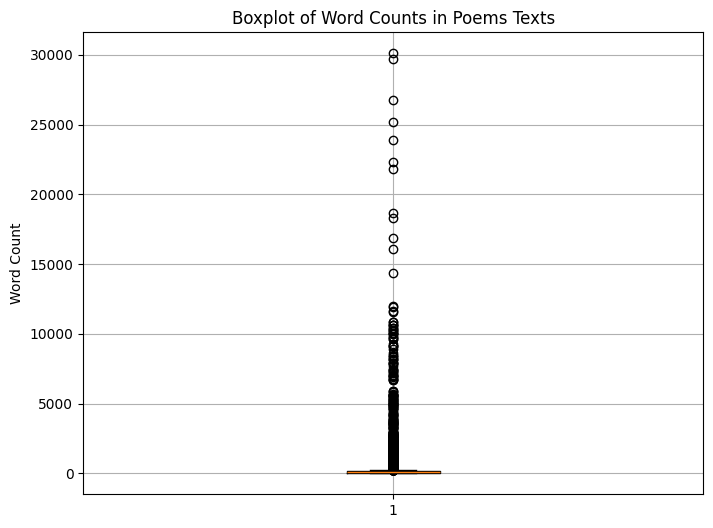

In [ ]:
# Boxplot for the 'word_counts' column
plt.figure(figsize=(8, 6))
plt.boxplot(df_poems['word_counts'], vert=True)
plt.title('Boxplot of Word Counts in Poems Texts')
plt.ylabel('Word Count')
plt.grid(True)
plt.show()

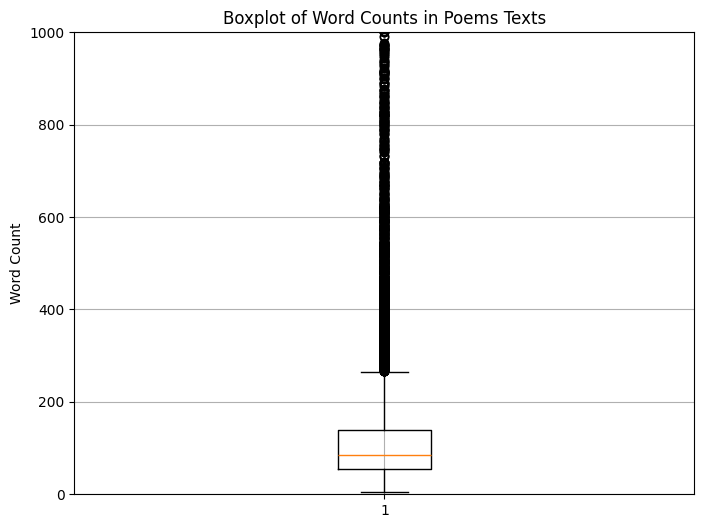

In [ ]:
plt.figure(figsize=(8, 6))
plt.boxplot(df_poems['word_counts'], vert=True)
plt.ylim(0, 1000)
plt.title('Boxplot of Word Counts in Poems Texts')
plt.ylabel('Word Count')
plt.grid(True)
plt.show()

In [ ]:
len(df_poems)

19302

In [ ]:
df_poems = df_poems[['title', 'texts', 'source', 'word_counts', 'genre']]

In [ ]:
# Save to file
df_poems.to_csv("data/original/poems.csv", index=False, encoding='utf-8')
print("File saved as poems.csv")

File saved as poems.csv
